In [2]:
#### cleansing 함수 비교

import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
from typing import Union, Literal

def cleansing_data_interpolation_IQR(data: pd.Series, mode: Literal['missing', 'outlier', 'both'] = 'both') -> pd.Series:
    """
    데이터의 누락치와 이상치를 처리하는 함수
    
    Args:
        data (pd.Series): 정제할 데이터
        mode (str): 정제 모드 ('missing', 'outlier', 'both' 중 하나)
    
    Returns:
        pd.Series: 정제된 데이터
    """
    data_cleaned = data.copy()

    if mode in ['missing', 'both']:  # 누락치 처리 (보간법)
        data_cleaned = data_cleaned.interpolate(method='linear')

    if mode in ['outlier', 'both']:  # 이상치 처리 (IQR 방법)
        Q1 = data_cleaned.quantile(0.25)
        Q3 = data_cleaned.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data_cleaned = np.where((data_cleaned < lower_bound) | (data_cleaned > upper_bound), np.nan, data_cleaned)
        data_cleaned = pd.Series(data_cleaned).interpolate(method='linear')

    return data_cleaned

def cleansing_data_Kalman_Filter(data: pd.Series, mode: Literal['missing', 'outlier', 'both'] = 'both', threshold_factor: float = 3) -> pd.Series:
    """
    칼만 필터를 사용하여 데이터의 누락치와 이상치를 처리하는 함수
    
    Args:
        data (pd.Series): 정제할 데이터
        mode (str): 정제 모드 ('missing', 'outlier', 'both' 중 하나)
        threshold_factor (float): 이상치 판별을 위한 임계값 계수
    
    Returns:
        pd.Series: 정제된 데이터
    """
    data_cleaned = data.copy()

    # 누락치를 평균으로 임시 대체
    data_filled = data_cleaned.fillna(data.mean())
    # 칼만 필터 초기화
    kf = KalmanFilter(initial_state_mean=data_filled.mean(), n_dim_obs=1)
    # 데이터의 누락치를 무시하고 칼만 필터 학습
    kf = kf.em(data_filled.values.reshape(-1, 1), n_iter=len(data_filled))
    
    # 칼만 필터를 사용하여 상태 추정
    state_means, state_covariances = kf.filter(data_filled.values.reshape(-1, 1))
    
    data_cleaned = data_filled.values
    
    if mode in ['missing', 'both']:
        # 누락치 대체
        data_cleaned = np.where(np.isnan(data), state_means[:, 0], data_cleaned)
    
    if mode in ['outlier', 'both']:
        # 잔차 계산
        residuals = data_cleaned - state_means[:, 0]
        # 임계값 설정 (예: 3 표준편차)
        threshold = threshold_factor * residuals.std()
        # 이상치 판별 및 대체
        data_cleaned = np.where(np.abs(residuals) > threshold, state_means[:, 0], data_cleaned)
    
    return pd.Series(data_cleaned, index=data.index)

#### Test

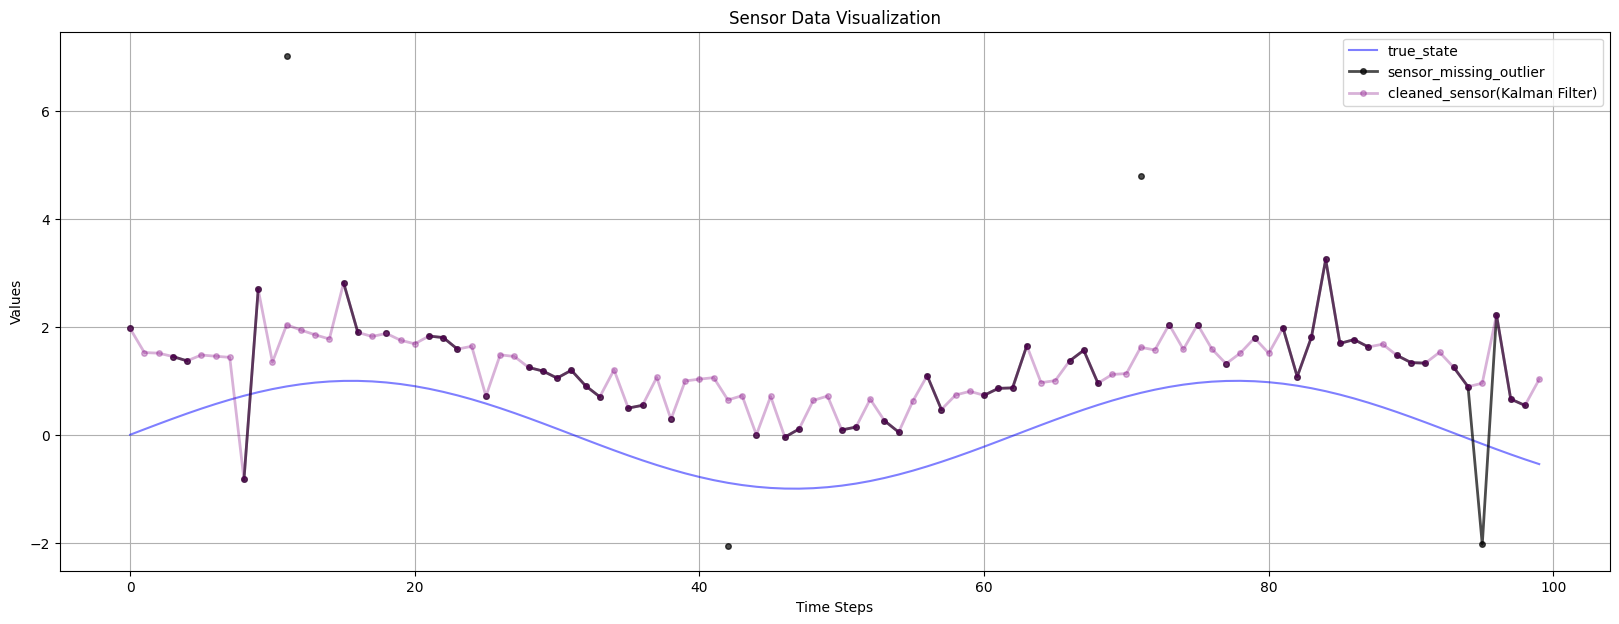

In [3]:
if __name__ == "__main__":

    # Test data
    np.random.seed(42)
    time_steps = 100
    true_state = np.sin(np.linspace(0, 10, time_steps))  # True system state
    data_noise = true_state + np.random.normal(0, 0.1, time_steps)  # Noisy measurements

    data_missing = data_noise.copy()
    missing_ratio=0.2
    n_missing = int(len(data_missing) * missing_ratio)
    missing_indices = np.random.choice(len(data_missing), n_missing, replace=False)
    data_missing[missing_indices] = np.nan

    data_outlier = data_noise.copy()
    outlier_ratio, outlier_factor = 0.3, 2
    n_outliers = int(len(data_outlier) * outlier_ratio)
    outlier_indices = np.random.choice(len(data_outlier), n_outliers, replace=False)
    data_outlier[outlier_indices] = data_outlier[outlier_indices] + np.random.normal(0, outlier_factor * np.std(data_noise), n_outliers)

    data_missing_outlier = data_outlier.copy()
    missing_ratio=0.4
    n_missing = int(len(data_missing_outlier) * missing_ratio)
    missing_indices = np.random.choice(len(data_missing_outlier), n_missing, replace=False)
    data_missing_outlier[missing_indices] = np.nan

    df = pd.DataFrame({
        'true_state': true_state,
        'sensor_noise': data_noise,
        'sensor_missing': data_missing,
        'sensor_outlier': data_outlier,
        'sensor_missing_outlier': data_missing_outlier
    })


    # Data cleansing
    cleaned_data_linear = cleansing_data_interpolation_IQR(df['sensor_missing_outlier'], mode='both')
    cleaned_data_kf = cleansing_data_Kalman_Filter(df['sensor_missing_outlier'], mode='both', threshold_factor=3)

    # Plotting the data
    plt.figure(figsize=(20, 7))

    plt.plot(true_state, label='true_state', color='blue', alpha=0.5)
    plt.plot(data_missing_outlier+1, label='sensor_missing_outlier', color='black', linestyle='solid', linewidth=2, marker='o', markersize=4, alpha=0.7)
    #plt.plot(cleaned_data_linear+1, label='cleaned_sensor(linear)', color='blue', linestyle='solid', linewidth=2, marker='o', markersize=4, alpha=0.3)
    plt.plot(cleaned_data_kf+1, label='cleaned_sensor(Kalman Filter)', color='purple', linestyle='solid', linewidth=2, marker='o', markersize=4, alpha=0.3)

    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.title('Sensor Data Visualization')
    plt.legend()
    plt.grid(True)
    plt.show()
